In [1]:
%load_ext autoreload

In [2]:
import os
import sys
import random
from typing import Tuple
import subprocess as sp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import cv2
import PIL
import plotnine as p9

import torch
import torchvision
import torchvision.transforms as T

In [3]:
%autoreload 2
from fundus_extractor.utils.general import imshow

In [4]:
def submit_slurm_array(training_save_dir: str, cmds: list, memory_in_gb: int, cores: int, gpu: bool, queue: str,
                       n_parallel_jobs: int, **kwargs) -> None:
    os.makedirs(training_save_dir, exist_ok=True)

    for ii, cmd in enumerate(cmds):
        job_dir = os.path.join(training_save_dir, f'run_{ii}') 
        os.makedirs(job_dir, exist_ok=True)
        job_file = f'{job_dir}/job.sh'
        out_file = f'{job_dir}/out.txt'
        err_file = f'{job_dir}/err.txt'
        with open(job_file, 'w') as handle:
            handle.writelines("#!/bin/bash\n")
            handle.writelines(f"source $HOME/.bashrc\n")
            handle.writelines(f"conda activate deepMMR\n")
            handle.writelines(f'{cmd} >> {out_file} 2>> {err_file}\n\n')
        os.chmod(job_file, 0o777)
        
    job_file = os.path.join(training_save_dir, 'job.sh')
    out_file = os.path.join(training_save_dir, 'out.txt')
    err_file = os.path.join(training_save_dir, 'err.txt')
    
    with open(job_file, 'w') as handle:
        handle.writelines("#!/bin/bash\n")

        handle.writelines('#SBATCH -J MMR_Job_Array\n')
        handle.writelines(f'#SBATCH -o {out_file}\n')
        handle.writelines(f'#SBATCH -e {err_file}\n')

        handle.writelines('#SBATCH -t 24:00:00\n')
        handle.writelines(f'#SBATCH -p {queue}\n')
        handle.writelines(f'#SBATCH -c {cores}\n')
        handle.writelines(f'#SBATCH --mem={memory_in_gb}GB\n')
        if gpu is True:
            handle.writelines('#SBATCH --gres=gpu:1\n')
        handle.writelines(f'#SBATCH -a 0-{len(cmds) - 1}%{n_parallel_jobs}\n')

        handle.writelines(f'cd {training_save_dir}\n')
        handle.writelines('./run_${SLURM_ARRAY_TASK_ID}/job.sh\n')

    sp.Popen(["sbatch", job_file], stdout=sp.PIPE, stderr=sp.PIPE)

# Preprocessing - transferGWAS

In [ ]:
input_dir = '/s/project/deepMMR/data/fundus/raw'
output_dir = '/s/project/deepMMR/data/fundus/processed_transferGWAS'

cmds = []
for left_right in os.listdir(input_dir):
    for folder in os.listdir(os.path.join(input_dir, left_right)):
        i = os.path.join(input_dir, left_right, folder)
        o = os.path.join(output_dir, left_right, folder)
        cmds.append(f'python3 /data/ouga/home/ag_gagneur/graef/Programs/transferGWAS/pretraining/resize.py {i} {o} --size 448')
print(cmds[0])

submit_slurm_array('/data/ouga/home/ag_gagneur/graef/tmp/slurm/img_processing', cmds, 8, 8, False, 'standard', 32)

# Preprocessing - EyeQ

In [11]:
base_dir = '/s/project/deepMMR/data/fundus/raw' 
save_dir = '/s/project/deepMMR/data/fundus/processed_EyeQ'
cmd = f'python3 /data/ouga/home/ag_gagneur/graef/EyeQ/EyeQ_preprocess/EyeQ_process_main.py --base_dir {base_dir} --save_dir {save_dir}'

submit_slurm_array('/data/ouga/home/ag_gagneur/graef/tmp/slurm/img_processing', [cmd], 32, 32, False, 'standard', 8)

# Image quality assessment - EyeQ/MCF_Net

In [6]:
base_dir = '/s/project/deepMMR/data/fundus/processed_EyeQ'
model_save_path = '/data/nasif12/home_if12/graef/tmp/DenseNet121_v3_v1.tar'
path_to_save_file = '/s/project/deepMMR/data/fundus/processed_transferGWAS/image_quality.tsv'

# os.system(f'python3 /data/ouga/home/ag_gagneur/graef/EyeQ/MCF_Net/run_inference.py --base_dir {base_dir} --model_save_path {model_save_path} --path_to_save_file {path_to_save_file}')

In [7]:
output_metric = pd.read_csv(path_to_save_file, sep='\t')
output_metric['eid'] = [x.split('.')[0].split('/')[-1].split('_')[0] for x in  output_metric['Path']]
output_metric['instance'] = ["_".join(x.split('.')[0].split('/')[-1].split('_')[2:]) for x in  output_metric['Path']]
output_metric['Eye'] = ['left' if x.split('.')[0].split('/')[-1].split('_')[1] == '21015' else 'right' for x in  output_metric['Path']]
output_metric

,Path,Good,Usable,Reject,eid,instance,Eye
0,/s/project/deepMMR/data/fundus/processed_EyeQ/...,0.963027,0.020378,0.016595,1178447,0_0,left
1,/s/project/deepMMR/data/fundus/processed_EyeQ/...,0.061463,0.147927,0.790610,1186186,0_0,left
2,/s/project/deepMMR/data/fundus/processed_EyeQ/...,0.022624,0.058615,0.918761,1181999,0_0,left
3,/s/project/deepMMR/data/fundus/processed_EyeQ/...,0.036510,0.029158,0.934332,1178854,0_0,left
4,/s/project/deepMMR/data/fundus/processed_EyeQ/...,0.024226,0.038245,0.937529,1173877,0_0,left
...,...,...,...,...,...,...,...
178696,/s/project/deepMMR/data/fundus/processed_EyeQ/...,0.945783,0.020158,0.034059,4607590,0_0,right
178697,/s/project/deepMMR/data/fundus/processed_EyeQ/...,0.981874,0.009907,0.008219,4614645,1_0,right
178698,/s/project/deepMMR/data/fundus/processed_EyeQ/...,0.022785,0.120756,0.856459,4607023,0_0,right
178699,/s/project/deepMMR/data/fundus/processed_EyeQ/...,0.769000,0.042615,0.188384,4623261,1_0,right


In [8]:
output_metric = output_metric.sort_values('Reject')

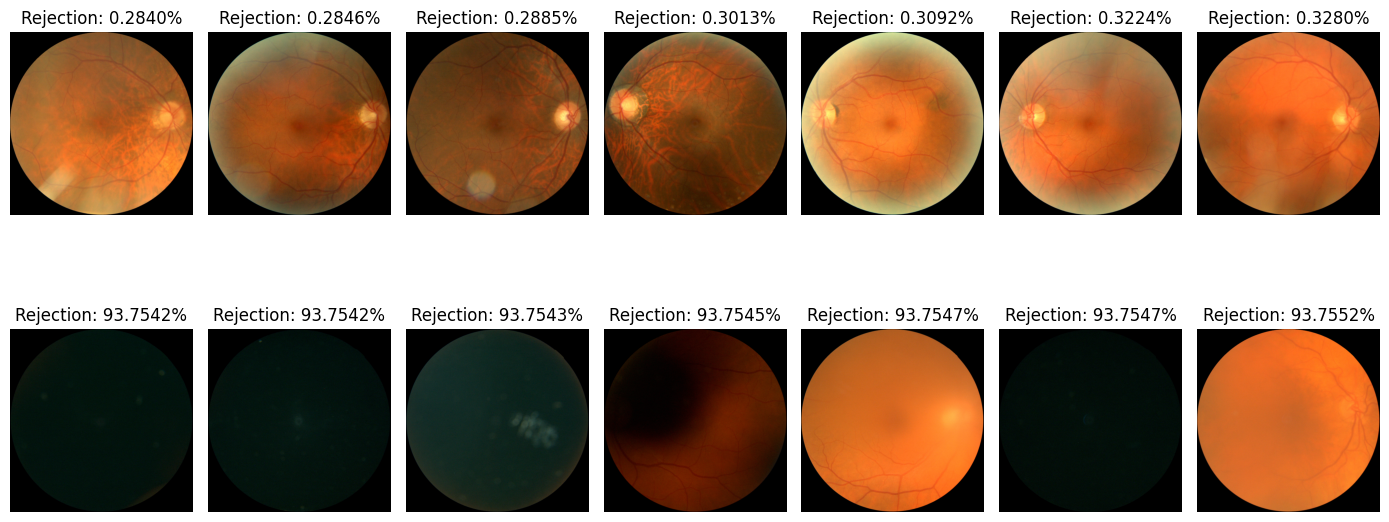

In [9]:
n_images = 7
fig, axes = plt.subplots(2, n_images, figsize=(14,7))

for ii, image_path in enumerate(output_metric.iloc[:n_images][['Reject', 'Path']].iterrows()):
    image = PIL.Image.open(image_path[1]['Path'])
    axes[0, ii].imshow(image)
    axes[0, ii].set_axis_off()
    axes[0, ii].set_title(f'Rejection: {image_path[1]["Reject"] * 100:.4f}%')

for ii, image_path in enumerate(output_metric.iloc[-n_images:][['Reject', 'Path']].iterrows()):
    image = PIL.Image.open(image_path[1]['Path'])
    axes[1, ii].imshow(image)
    axes[1, ii].set_axis_off()
    axes[1, ii].set_title(f'Rejection: {image_path[1]["Reject"] * 100:.4f}%')
fig.tight_layout()
fig.savefig('/data/ouga/home/ag_gagneur/graef/tmp/Fundus_Quality.png')

In [10]:
plot = p9.ggplot(output_metric, p9.aes(x='Reject * 100', color='Eye'))
plot += p9.geom_histogram(bins=30, position=p9.position_dodge())
plot += p9.xlab('Reject score per image [%]')
plot.draw().savefig('/data/ouga/home/ag_gagneur/graef/tmp/Fundus_Rejection.png')

In [11]:
output_metric_both_eyes = output_metric.groupby(['eid', 'instance']).filter(lambda x: len(x) == 2)[['eid', 'instance', 'Eye', 'Reject']]
output_metric_both_eyes = output_metric_both_eyes.pivot_table(index=['eid', 'instance'], columns='Eye', values='Reject').reset_index()
output_metric_both_eyes[['left', 'right']].corr()

Eye,left,right
Eye,,
left,1.000000,0.669062
right,0.669062,1.000000


In [12]:
eids_good_quality_df = output_metric[output_metric['Reject'] < 0.66]
eids_good_quality_df = eids_good_quality_df.groupby(['eid', 'instance']).filter(lambda x: len(x) == 2)[['eid', 'instance']]
eids_good_quality_df = eids_good_quality_df.sort_values('instance')
eids_good_quality_df = eids_good_quality_df.groupby('eid').last().reset_index()
eids_good_quality_df.to_csv('/s/project/deepMMR/data/fundus/processed_transferGWAS/good_eids.tsv', sep='\t')